In [1]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from goleta import data as D
from goleta import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis_tng = U.read_best_ndes('qphi.tng.omega_theta', device=device)
qphis_sim = U.read_best_ndes('qphi.simba.omega_theta', device=device)

140 models trained
[130, 135, 138, 136, 137]
121 models trained
[90, 103, 88, 93, 106]


In [6]:
with h5py.File('/tigress/chhahn/goleta/tng.snap33.subfind.galaxies.LHC.hdf5', 'r') as f:
    tng_props = f['props'][...].T
    
with h5py.File('/tigress/chhahn/goleta/simba.snap33.subfind.galaxies.LHC.hdf5', 'r') as f:
    sim_props = f['props'][...].T    

In [7]:
y_tng, x_tng = D.get_data('test', 'omega', 'theta', sim='tng', downsample=True)
y_sim, x_sim = D.get_data('test', 'omega', 'theta', sim='simba', downsample=True)

In [8]:
# get corresponding SFRs
_tng = np.array([np.log10(tng_props[:,i]) for i in [6, 7 , 10, 13, 17]]).T
_sim = np.array([np.log10(sim_props[:,i]) for i in [6, 7 , 10, 13, 17]]).T

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
sfr_tng = np.array([np.log10(tng_props[np.argmin(np.sum(np.abs(_tng - x_tng[i]), axis=1)),14]) 
                     for i in range(len(x_tng))])
sfr_sim = np.array([np.log10(sim_props[np.argmin(np.sum(np.abs(_sim - x_sim[i]), axis=1)),14]) 
                     for i in range(len(x_sim))])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


## select intermediate star forming galaxies

In [10]:
# is_sfr = ((x_tng[:,1] > 9.4) & (x_tng[:,1] < 9.5) & 
#           (sfr_tng > -0.4) & (sfr_tng < -0.2))
# i_tng = np.random.choice(np.arange(x_tng.shape[0])[is_sfr], size=1)

# is_sfr = ((x_sim[:,1] > 9.4) & (x_sim[:,1] < 9.5) & 
#           (sfr_sim > -0.4) & (sfr_sim < -0.2))
# i_sim = np.random.choice(np.arange(x_sim.shape[0])[is_sfr], size=1)

i_tng = 8623
i_sim = 1933

(-2.5, 2.0)

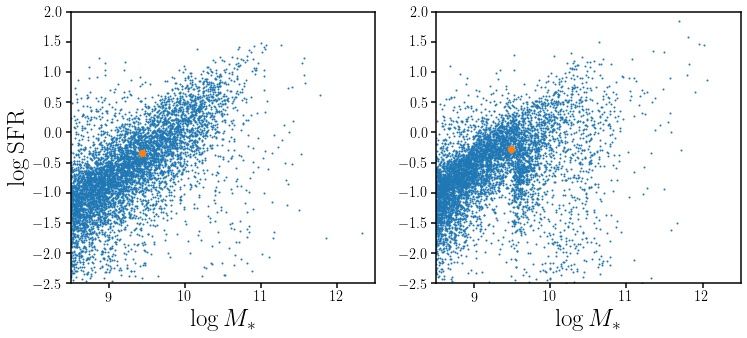

In [11]:
fig = plt.figure(figsize=(12,5))
sub = fig.add_subplot(121)
sub.scatter(x_tng[:,1], sfr_tng, s=1)
sub.scatter(x_tng[i_tng,1], sfr_tng[i_tng], s=40)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.5)
sub.set_ylabel(r'$\log {\rm SFR}$', fontsize=25)
sub.set_ylim(-2.5, 2)

sub = fig.add_subplot(122)
sub.scatter(x_sim[:,1], sfr_sim, s=1)
sub.scatter(x_sim[i_sim,1], sfr_sim[i_sim], s=40)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(8.5, 12.5)
#sub.set_ylabel(r'$\log {\rm SFR}$', fontsize=25)
sub.set_ylim(-2.5, 2)

In [12]:
x_tng[i_tng,:], x_sim[i_sim,:]

(array([10.66903445,  9.42862441,  2.12135649, -2.01569504, -2.58004233]),
 array([10.23258114,  9.47716236,  2.23129582, -2.2398293 , -2.50948286]))

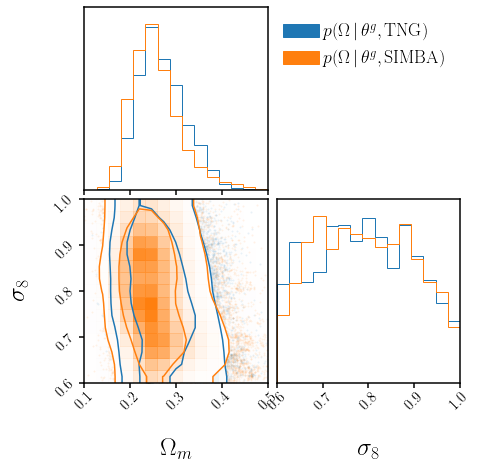

In [20]:
tng_samp = [] 
for i, qphi in enumerate(qphis_tng): 
    _samp = qphi.sample((10000,),
                       x=torch.tensor(x_tng[i_tng], dtype=torch.float32).to(device), 
                       show_progress_bars=False)
    tng_samp.append(_samp.detach().cpu().numpy())
tng_samp = np.concatenate(tng_samp)
     
sim_samp = [] 
for i, qphi in enumerate(qphis_sim): 
    _samp = qphi.sample((10000,),
                       x=torch.tensor(x_sim[i_sim], dtype=torch.float32).to(device), 
                       show_progress_bars=False)
    sim_samp.append(_samp.detach().cpu().numpy())    
sim_samp = np.concatenate(sim_samp)    

lbls = [r'$\Omega_m$', r'$\sigma_8$']
#_range = [(0.15, 0.45), (0.65, 0.95)]
_range = [(0.1, 0.5), (0.6, 1.)]

fig = plt.figure(figsize=(7,7))
_ = DFM.corner(tng_samp[:,:2], range=_range, bins=15, levels=[0.64, 0.95], smooth=True,
               hist_kwargs={'density': True}, color='C0', 
               labels=lbls, label_kwargs={'fontsize': 25}, fig=fig)
_ = DFM.corner(sim_samp[:,:2], range=_range, bins=15, levels=[0.64, 0.95], smooth=True,
               hist_kwargs={'density': True}, color='C1', 
               labels=lbls, label_kwargs={'fontsize': 25}, fig=fig)
    
ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))
for i in range(ndim): 
    for j in range(ndim):
        axes[i,j].set_xlim(_range[j])
        if j < i: 
            axes[i,j].set_ylim(_range[i])
            if i == 1: 
                axes[i,j].set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
                axes[i,j].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
        if i == j and i == 1:  
            axes[i,j].set_xticks([0.6, 0.7, 0.8, 0.9, 1.0])
        if i == j and i == 0:  
            axes[i,j].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])            

axes[0,1].fill_between([], [], [], color='C0', label=r'$p(\Omega\,|\,\theta^g, {\rm TNG})$')
axes[0,1].fill_between([], [], [], color='C1', label=r'$p(\Omega\,|\,\theta^g, {\rm SIMBA})$')
axes[0,1].legend(loc='upper right', fontsize=18, handletextpad=0.15)

fig.savefig('../figs/p_omega_theta.pdf', bbox_inches='tight')